In [7]:
import uproot
import vector
import awkward as ak
import numpy as np
import matplotlib.pyplot as plt
import glob
from tqdm import tqdm  # ✅ 진행률 표시

vector.register_awkward()

# 모든 .root 파일 경로 가져오기
path = "/data6/Users/snuintern1/LRSM_tb_channel/SAMPLEPRODUCTION/WRtoNMutoMuMuTB-HadTop_MWR-5000_MN-2500_13p6TeV/"
file_list = sorted(glob.glob(path + "*.root"))

# 누적 리스트
def delta_phi(phi1, phi2):
    d = phi1 - phi2
    # wrap to [-π, +π]
    return (d + np.pi) % (2*np.pi) - np.pi

def delta_r(deta, dphi):
    return np.sqrt(d_eta**2 + d_phi**2)

total_events = 0
less_than_08_1 = 0
less_than_08_2 = 0
all_dr = []
all_dr_2 = []

# tqdm으로 파일 리스트 순회
for sample in tqdm(file_list, desc="Processing ROOT files"):
    file = uproot.open(sample)
    events = file["Events"]

    lhe_pdgid = events["LHEPart_pdgId"].array()
    lhe_pt = events["LHEPart_pt"].array()
    lhe_eta = events["LHEPart_eta"].array()
    lhe_phi = events["LHEPart_phi"].array()
    lhe_mass = events["LHEPart_mass"].array()
    lhe_status = events["LHEPart_status"].array()

    gen_pdgid = events["GenPart_pdgId"].array()
    gen_pt = events["GenPart_pt"].array()
    gen_eta = events["GenPart_eta"].array()
    gen_phi = events["GenPart_phi"].array()

    topmask = (gen_pdgid == 6) | (gen_pdgid == -6)
    top_eta = gen_eta[topmask]
    top_phi1 = gen_phi[topmask]

    ## Fatjet 
    fatjet_pt = events["FatJet_pt"].array()
    fatjet_eta = events["FatJet_eta"].array()
    fatjet_phi = events["FatJet_phi"].array()
    fatjet_mass = events["FatJet_mass"].array()

    muon_mask = (lhe_pdgid == 13) | (lhe_pdgid == -13)
    bottom_mask = (lhe_pdgid == 5) | (lhe_pdgid == -5)

    bottom_eta = lhe_eta[bottom_mask]
    bottom_phi = lhe_phi[bottom_mask]
    bottom_pt = lhe_pt[bottom_mask]

    def delta_phi(phi1, phi2):
        d = phi1 - phi2
        # wrap to [-π, +π]
        return (d + np.pi) % (2*np.pi) - np.pi

    def delta_r(eta1, phi1, eta2, phi2):
        d_eta = eta1 - eta2
        d_phi = delta_phi(phi1, phi2)
        return np.sqrt(d_eta**2 + d_phi**2)

#lepton , muon 2 = WR mother
#lepton , muon 1 = n mother
#bottom quark 2 = WR* mother
#bottom quark 1 = t mother  


    bottompt1 = bottom_pt[:, 0]#bottom quark 0 = top mother
    bottompt2 = bottom_pt[:, 1]#bottom quark 1 = WR* mother

    bottom_eta1 = bottom_eta[:, 0]#bottom quark 0 = top mother
    bottom_eta2 = bottom_eta[:, 1]#bottom quark 1 = WR* mother
    bottom_phi1 = bottom_phi[:, 0]#bottom quark 0 = top mother
    bottom_phi2 = bottom_phi[:, 1]#bottom quark 1 = WR* mother

    for i in range(len(fatjet_pt)):
        
        if ((bottompt2[i]) != 0 ):
            if len(top_eta[i])  < 2:  # top_eta[i]가 비어있거나 길이가 1보다 작은 경우 건너뛰기
                continue
            # fatjet
            total_events += 1
            top_etas = top_eta[i][0]
            top_phi = top_phi1[i][0]
    
            delta_eta = fatjet_eta[i] - top_etas
    
            delta_phi = fatjet_phi[i] -top_phi 
            delta_phi = (delta_phi + np.pi) % (2 * np.pi) - np.pi  # wrap to [-π, +π]
            #ΔR 계산
            dr_jet = np.sqrt(delta_eta**2 + delta_phi**2)
            if len(dr_jet) >1:
                idx = np.argsort(dr_jet)[0] #top AK8 jet index
                ## muon 중에 ak8 jet 과 R < 0.8 인 jet 갯수 찾기 
                ak8_eta = fatjet_eta[i][idx]
                ak8_phi = fatjet_phi[i][idx]


                ## WR* mother bottom quark
                delta_eta1 = bottom_eta2[i] - ak8_eta
                delta_phi1 = bottom_phi2[i] - ak8_phi
                delta_phi1 = (delta_phi1 + np.pi) % (2 * np.pi) - np.pi
                dr_bottom1 = np.sqrt(delta_eta1**2 + delta_phi1**2)
                all_dr.append(dr_bottom1)
                if dr_bottom1 < 0.8:
                    less_than_08_1 += 1
        if ((bottompt1[i]) != 0 ):
            if len(top_eta[i])  < 2:  # top_eta[i]가 비어있거나 길이가 1보다 작은 경우 건너뛰기
                continue
                # fatjet
            top_etas = top_eta[i][0]
            top_phi = top_phi1[i][0]
            delta_eta = fatjet_eta[i] - top_etas
            delta_phi = fatjet_phi[i] -top_phi
            delta_phi = (delta_phi + np.pi) % (2 * np.pi) - np.pi  # wrap to [-π, +π]
            #ΔR 계산
            dr_jet = np.sqrt(delta_eta**2 + delta_phi**2)
            if len(dr_jet) >1:
                idx = np.argsort(dr_jet)[0]
                ## t mother bottom quark
                delta_eta2 = bottom_eta1[i] - ak8_eta
                delta_phi2 = bottom_phi1[i] - ak8_phi
                delta_phi2 = (delta_phi2 + np.pi) % (2 * np.pi) - np.pi
                dr_bottom2 = np.sqrt(delta_eta2**2 + delta_phi2**2)
                all_dr_2.append(dr_bottom2)
                if dr_bottom2 > 0.8:
                    less_than_08_2 += 1
    
    




Processing ROOT files: 100%|██████████| 114/114 [16:40<00:00,  8.78s/it]


Number of WR* mother bottom quarks with Delta R < 0.8:  4710
Number of t mother bottom quarks outside of AK8  12591
Total events processed:  56759


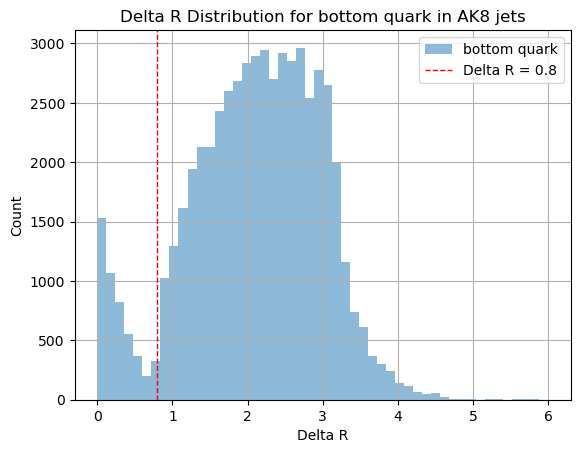

"plt.hist(dphi1, bins=50, range=(-np.pi, np.pi), alpha=0.5, label='bottom quark')"

In [8]:
print("Number of WR* mother bottom quarks with Delta R < 0.8: ", less_than_08_1)
print("Number of t mother bottom quarks outside of AK8 ", less_than_08_2)
print("Total events processed: ", total_events)
plt.hist(all_dr, bins=50, range=(0, 6), alpha=0.5, label='bottom quark')
plt.axvline(0.8, color='red', linestyle='dashed', linewidth=1, label='Delta R = 0.8')
plt.xlabel('Delta R')
plt.ylabel('Count')
plt.title('Delta R Distribution for bottom quark in AK8 jets')
plt.legend()
plt.grid()
plt.show()

"plt.hist(dphi1, bins=50, range=(-np.pi, np.pi), alpha=0.5, label='bottom quark')"